<a href="https://colab.research.google.com/github/GiselleMelo/Ubiquity/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hypothesis 1: From 2021-2022 air quality must have worsened due to the return of human activities

Loading data

In [7]:
# Detailed air quality data (April 2022)
path_air = 'AirView_DublinCity_Measurements_ugm3.csv'
air = pd.read_csv(path_air)

The air quality dataset contains high-resolution measurements (3 second intervals but not counting weekends and it's only on during the day) starting in may 2021 in the city of Dublin.
Our first Hypothesis is mainly focused on air quality, being that in 2021-2022 there was a big transition to flow in terms of cars, biking, people, we wondered if the air quality from these covid years worsened from 2021 where restrictions were higher to 2022.

Processing the air quality data

In [8]:
# Load full air quality dataset
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
cols = ['gps_timestamp'] + pollutants

air_2 = pd.read_csv(path_air, usecols=cols, parse_dates=['gps_timestamp'], low_memory=False)

# Filter for April to September 2022
#air_2 = air_2[(air_2['gps_timestamp'] >= '2022-04-01') & (air['gps_timestamp'] <= '2022-09-30')]

# Remove negative values
for col in pollutants:
   air_2 = air_2[air_2[col] >= 0]

# Create week number
air_2['Week'] = air_2['gps_timestamp'].dt.isocalendar().week

# Aggregate weekly averages for each pollutant
air_weekly = air_2.groupby('Week')[pollutants].mean().reset_index()


In [9]:
air_2.head(5)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


# Air quality DataBase

In [10]:
def calculateMean(data, columns):
    meanData = []
    for col in columns:
        meanData.append(data[col].mean())
    return meanData

In [11]:
air_2.head(5) # The air database is updated every few seconds, so for a better analysis we devide that

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


In [12]:
air_ts = air_2.copy() #the data is not sorted by date as it starts on a random date so we have to organize it,creating a copy to not mess the last part of the code

In [13]:
air_ts = air_ts.sort_values('gps_timestamp').reset_index(drop=True)

In [14]:
# adds column hour
air_ts['Hour'] = air_ts['gps_timestamp'].dt.hour
# extract date
air_ts['Day_date'] = air_ts['gps_timestamp'].dt.date
# sequency (1, 2, 3, ...)
air_ts['Day_number'] = (air_ts['Day_date'] != air_ts['Day_date'].shift()).cumsum()
# the time stamp starts on april 6th 2022, a Thursday
air_ts

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week,Hour,Day_date,Day_number
0,2021-05-06 12:31:02+00:00,40.546,33.507,38.240,0.321,805.010,2.997,18,12,2021-05-06,1
1,2021-05-06 12:31:05+00:00,18.509,36.554,40.461,0.306,805.227,3.027,18,12,2021-05-06,1
2,2021-05-06 12:49:19+00:00,14.343,34.920,47.564,0.387,823.322,3.516,18,12,2021-05-06,1
3,2021-05-06 12:49:21+00:00,16.713,34.257,46.232,0.357,823.363,4.089,18,12,2021-05-06,1
4,2021-05-06 12:49:41+00:00,38.833,19.110,58.664,0.322,804.591,2.543,18,12,2021-05-06,1
...,...,...,...,...,...,...,...,...,...,...,...
388649,2022-07-28 10:59:56+00:00,59.159,18.723,48.675,0.463,811.102,4.123,30,10,2022-07-28,272
388650,2022-07-28 12:07:36+00:00,15.010,6.556,55.111,0.456,763.760,3.464,30,12,2022-07-28,272
388651,2022-07-28 12:29:19+00:00,14.704,2.481,54.002,0.362,784.975,3.690,30,12,2022-07-28,272
388652,2022-08-05 09:33:51+00:00,1.415,49.455,50.785,0.304,833.969,1.864,31,9,2022-08-05,273


In [15]:
air_ts['gps_timestamp'] = pd.to_datetime(air_ts['gps_timestamp'])

In [16]:
print(sorted(air_ts['Day_date'].unique()))

[datetime.date(2021, 5, 6), datetime.date(2021, 5, 7), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 12), datetime.date(2021, 5, 13), datetime.date(2021, 5, 14), datetime.date(2021, 5, 17), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 24), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 5, 27), datetime.date(2021, 5, 31), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 3), datetime.date(2021, 6, 4), datetime.date(2021, 6, 8), datetime.date(2021, 6, 9), datetime.date(2021, 6, 10), datetime.date(2021, 6, 11), datetime.date(2021, 6, 14), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 6, 18), datetime.date(2021, 6, 21), datetime.date(2021, 6, 22), datetime.date(2021, 6, 23), datetime.date(2021, 6, 24), datetime.date(2021, 6, 25), datetime.date(2021, 6, 28), datetime.date(2021, 6, 29), datetime.date(2021, 6, 30),

Analysing the days, we can see that the data collection skeeps weekends and some times some days of the week, but that still allows for a daily week day analysis

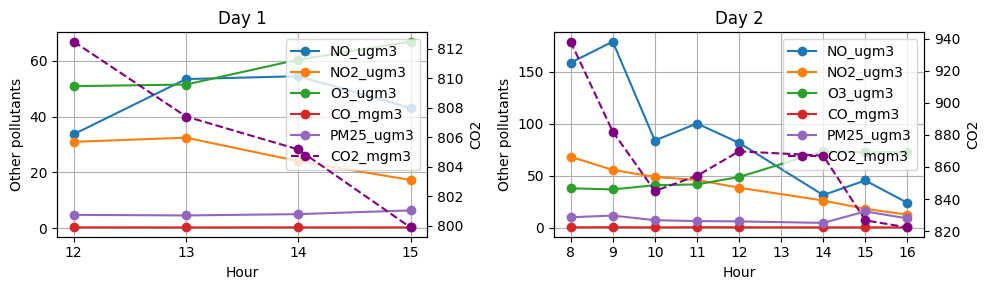

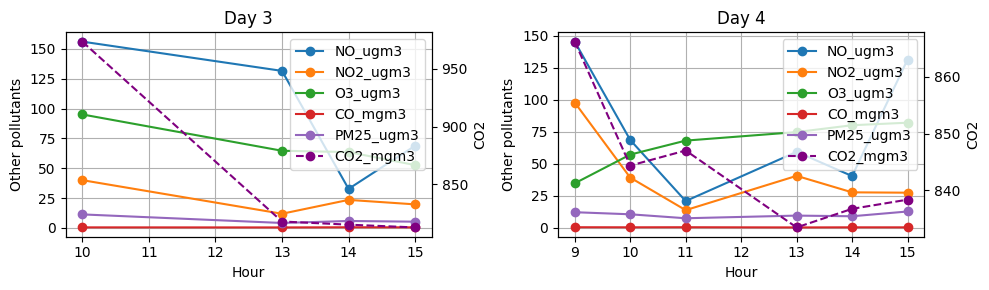

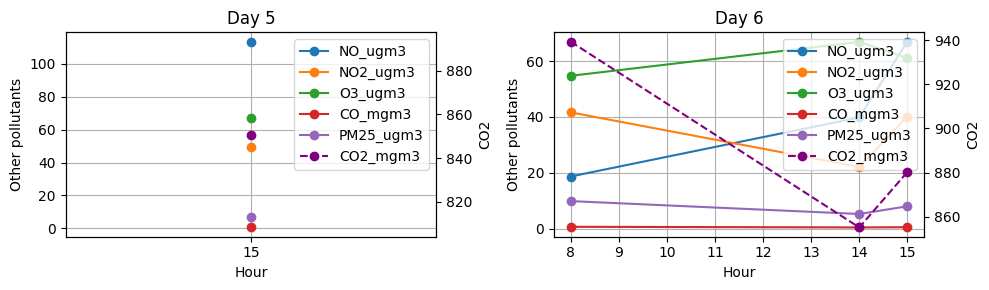

last week


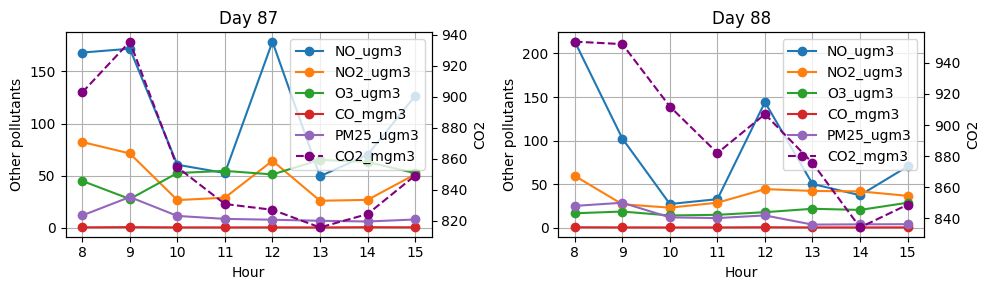

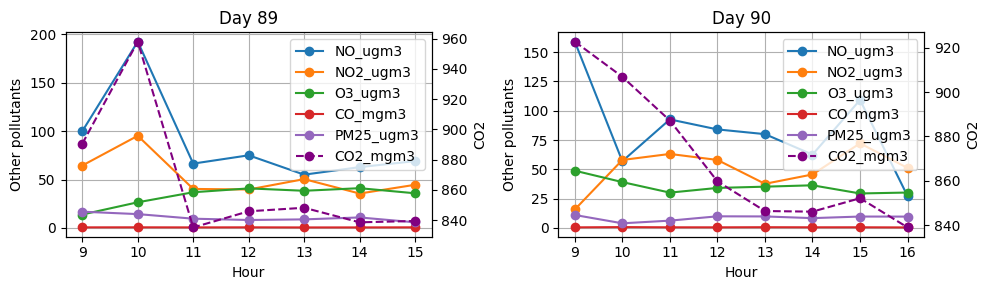

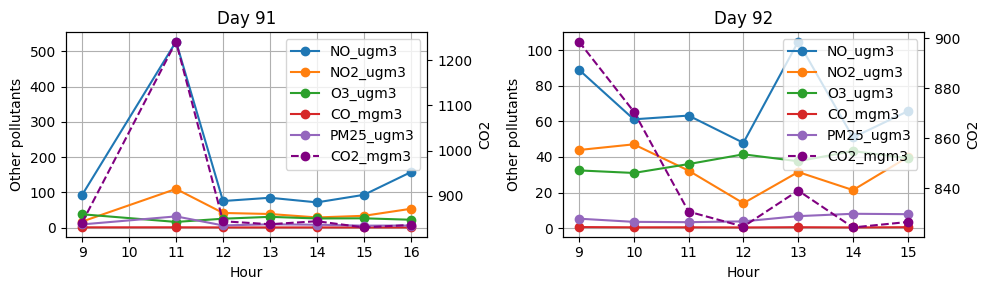

In [17]:
import matplotlib.pyplot as plt

def plot_pollutants_by_hour(air_ts, pollutants, day_numbers):
    # Cria uma figura com N subplots lado a lado
    fig, axes = plt.subplots(1, len(day_numbers), figsize=(5 * len(day_numbers), 3))  # Ajusta o tamanho

    # Garante que axes seja iterável, mesmo com um único subplot
    if len(day_numbers) == 1:
        axes = [axes]

    for ax, day_number in zip(axes, day_numbers):
        df_filtered = air_ts[air_ts['Day_number'] == day_number]
        hourly_means = df_filtered.groupby('Hour')[pollutants].mean().reset_index()

        main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

        # Eixo principal
        for pollutant in main_pollutants:
            ax.plot(hourly_means['Hour'], hourly_means[pollutant], label=pollutant, marker='o')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Other pollutants')
        ax.set_title(f'Day {day_number}')
        ax.grid(True)
        ax.set_xticks(range(0,24))

        # Eixo secundário para CO2
        ax2 = ax.twinx()
        ax2.plot(hourly_means['Hour'], hourly_means['CO2_mgm3'], label='CO2_mgm3', color='purple', marker='o', linestyle='--')
        ax2.set_ylabel('CO2')

        # Combina legendas
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[1,2])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[3,4])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[5,6])
print('last week')
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[87,88])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[89,90])
plot_pollutants_by_hour(air_ts, pollutants, day_numbers=[91,92])

Understanding the Daily analysis we can see that some days the data was not very well collected so we can try to take those days off (with less than 4 hours of collection) of consideration to get a deeper analysis

Also looking at the data we can see that the values are very inconsistant throughout the day and that there wasn't much change in air pollution parterns during the day doesn't really have a clear pattern. We could explore that better, but the important thing for the Hypothesis is to understand the transition along the years, so we need to expand the look

Before getting the mean for the days we need to take of the days with very few data, so we leave the ones that have at least 4 hours of data collection

In [18]:
hours_per_day = air_ts.groupby('Day_number')['Hour'].nunique()
valid_days = hours_per_day[hours_per_day >= 4].index
air_ts_filtered = air_ts[air_ts['Day_number'].isin(valid_days)].reset_index(drop=True)
air_ts_filtered.head(2)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week,Hour,Day_date,Day_number
0,2021-05-06 12:31:02+00:00,40.546,33.507,38.240,0.321,805.010,2.997,18,12,2021-05-06,1
1,2021-05-06 12:31:05+00:00,18.509,36.554,40.461,0.306,805.227,3.027,18,12,2021-05-06,1


In [19]:
# This section separates de Air quality database into Hour and Days to make an analysis time based
air_ts_filtered['gps_timestamp'] = pd.to_datetime(air_ts_filtered['gps_timestamp'])
# For the hourly analysis
air_daily = air_ts_filtered.groupby('Day_number')[pollutants].mean().reset_index()
air_daily

,Day_number,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
0,1,50.769820,27.731534,56.170355,0.381856,806.019869,5.064824
1,2,110.681767,47.480455,44.128436,0.475246,868.542723,8.516241
2,3,63.942942,22.629391,63.232522,0.463304,828.542058,5.920870
3,4,86.025758,46.042063,62.062323,0.419108,845.408502,10.843773
4,7,73.936124,43.438385,51.740931,0.493717,870.399645,10.537708
...,...,...,...,...,...,...,...
231,254,36.542416,25.426909,33.161781,0.431323,815.096966,8.322774
232,260,90.170321,55.567246,19.109201,0.426328,820.763910,7.105761
233,263,48.255978,23.051469,22.649931,0.332956,787.438975,3.659825
234,270,20.708717,16.200283,33.173022,0.321130,759.958804,2.578457


In [20]:
air_daily['Day_block'] = ((air_daily['Day_number'] - air_daily['Day_number'].min()) // 5) + 1
air_5days = air_daily.groupby('Day_block')[pollutants].mean().reset_index()
day_ranges = air_daily.groupby('Day_block')['Day_number'].agg(['min', 'max']).reset_index()
air_5days = pd.merge(air_5days, day_ranges, on='Day_block')

This is hard to visualize given the amount of data, but if we split it into 20 days it is better to visualize

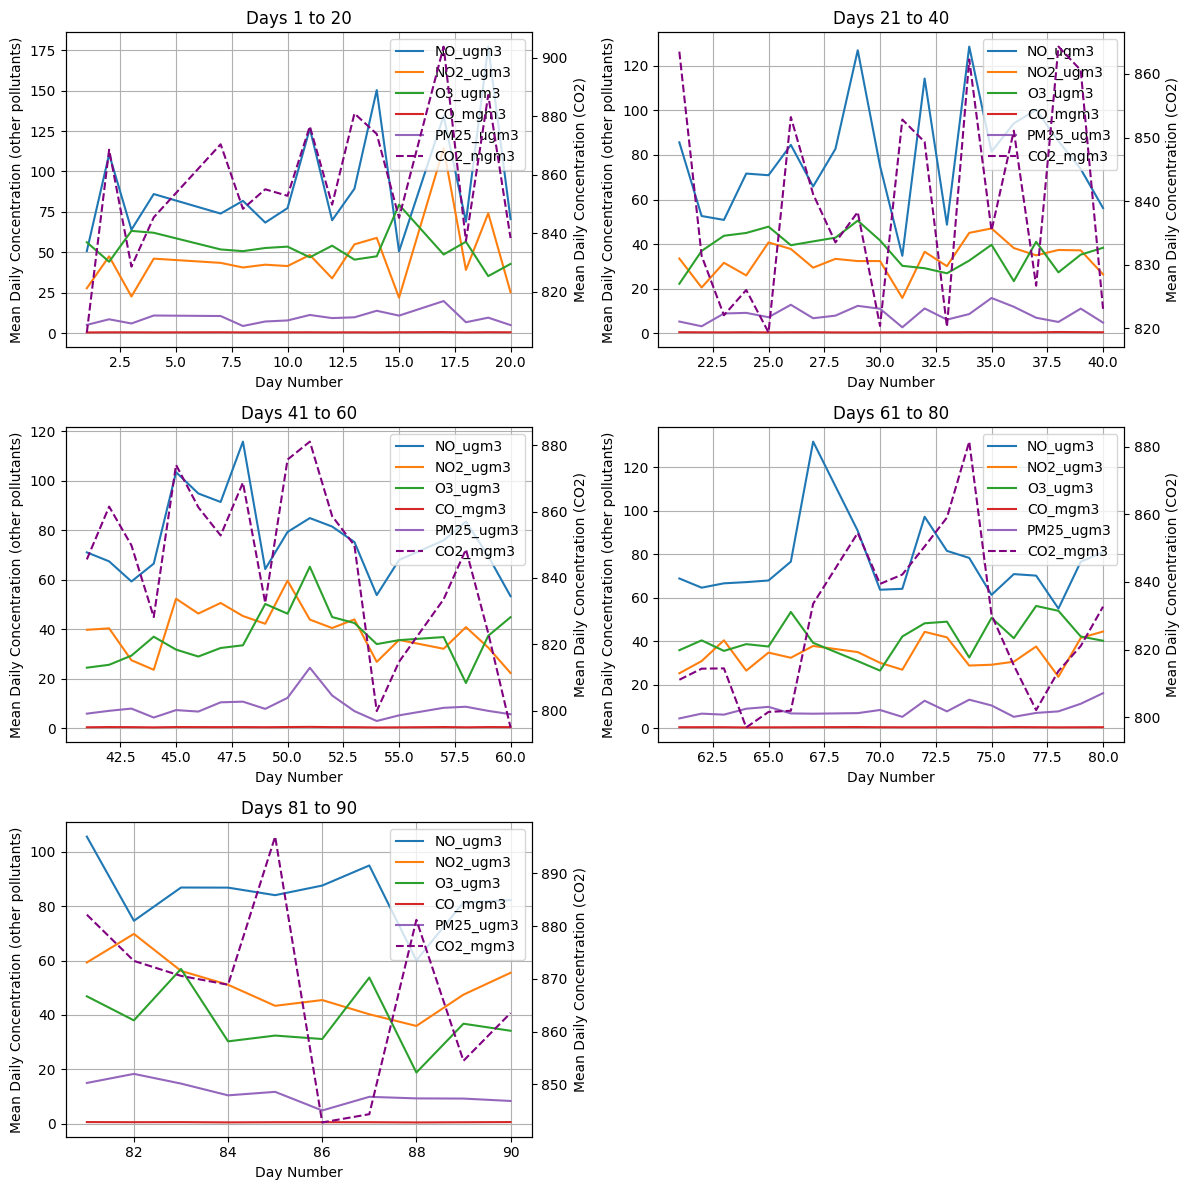

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_daily_pollutants(air_daily, pollutants, day_start, day_end, days_per_plot=20):
    # Filtra os dias dentro do intervalo desejado
    df_filtered = air_daily[(air_daily['Day_number'] >= day_start) & (air_daily['Day_number'] <= day_end)]

    # Define quantos gráficos vai precisar (2 por linha)
    total_days = day_end - day_start + 1
    num_plots = int(np.ceil(total_days / days_per_plot))

    fig, axes = plt.subplots(num_plots // 2 + num_plots % 2, 2, figsize=(12, 4 * (num_plots // 2 + num_plots % 2)))
    axes = axes.flatten()  # Deixa a matriz de eixos como uma lista

    main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

    for i in range(num_plots):
        day_range_start = day_start + i * days_per_plot
        day_range_end = min(day_range_start + days_per_plot - 1, day_end)

        df_chunk = df_filtered[(df_filtered['Day_number'] >= day_range_start) & (df_filtered['Day_number'] <= day_range_end)]

        ax1 = axes[i]

        # Eixo principal
        for pollutant in main_pollutants:
            ax1.plot(df_chunk['Day_number'], df_chunk[pollutant], label=pollutant)
        ax1.set_xlabel('Day Number')
        ax1.set_ylabel('Mean Daily Concentration (other pollutants)')
        ax1.set_title(f'Days {day_range_start} to {day_range_end}')
        ax1.grid(True)

        # Eixo secundário para CO2
        ax2 = ax1.twinx()
        ax2.plot(df_chunk['Day_number'], df_chunk['CO2_mgm3'], label='CO2_mgm3', color='purple', linestyle='--')
        ax2.set_ylabel('Mean Daily Concentration (CO2)')

        # Junta as legendas
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # Remove plots vazios (se o número de plots for ímpar)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_daily_pollutants(air_daily, pollutants, day_start=1, day_end=90, days_per_plot=20)

Analysing the picture the values are actualy very inconsistent

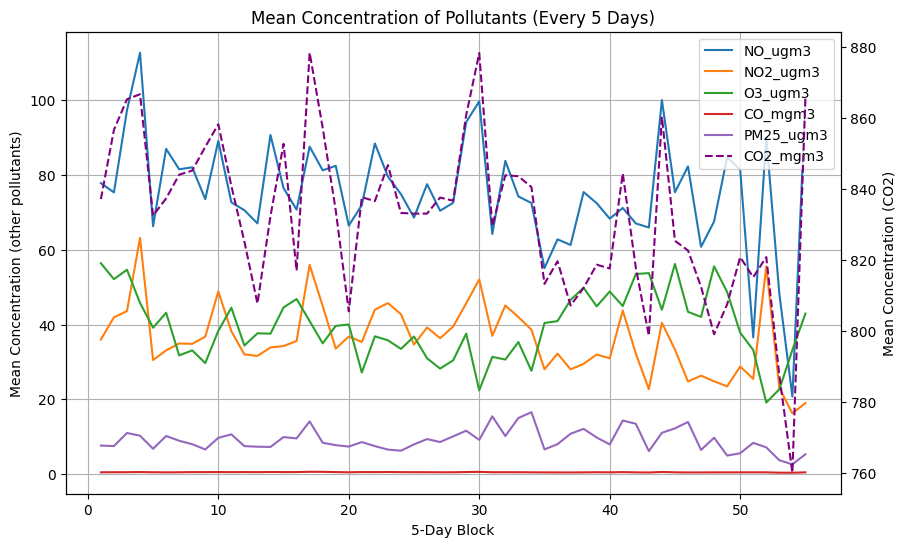

In [22]:
import matplotlib.pyplot as plt

def plot_5day_pollutants(air_5days, pollutants):
    main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

    fig, ax1 = plt.subplots(figsize=(10,6))

    for pollutant in main_pollutants:
        ax1.plot(air_5days['Day_block'], air_5days[pollutant], label=pollutant)
    ax1.set_xlabel('5-Day Block')
    ax1.set_ylabel('Mean Concentration (other pollutants)')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(air_5days['Day_block'], air_5days['CO2_mgm3'], label='CO2_mgm3', color='purple', linestyle='--')
    ax2.set_ylabel('Mean Concentration (CO2)')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Mean Concentration of Pollutants (Every 5 Days)')
    plt.show()

plot_5day_pollutants(air_5days, pollutants)

Seeing this last comparison we can actually see a slight decrease in the concentration of pollutants, with the exeption of O3, that shows that activities in 2021 were already up, or that it just didn't impact the quality of the air being back into action from 2021-2022. Our Hypothesis was refutaded

# Hypothesis 2: Better air quality = more people cycling/walking

In [23]:
# Load both datasets (adjust paths as needed)
cycle_df = pd.read_csv('cycle-counts-2022.csv', parse_dates=['Time'], dayfirst=True)
pedestrian_df = pd.read_csv('pedestrian-counts-2022.csv', parse_dates=['Time'], dayfirst=True)

# Sum all count columns (excluding Time)
cycle_df['TotalCyclists'] = cycle_df.drop(columns=['Time']).sum(axis=1)
pedestrian_df['TotalPedestrians'] = pedestrian_df.drop(columns=['Time']).sum(axis=1)

# Combine pedestrian and cyclist counts
people_df = pd.DataFrame()
people_df['Time'] = cycle_df['Time']  # assume time columns match
people_df['TotalPeople'] = cycle_df['TotalCyclists'] + pedestrian_df['TotalPedestrians']

# Add ISO week number
people_df['Week'] = people_df['Time'].dt.isocalendar().week

# Weekly average of total people (cycling + walking)
weekly_people = people_df.groupby('Week')['TotalPeople'].mean().reset_index()


#  Pedestrian DataBase

In [24]:
pedestrian_df

,Time,Aston Quay/Fitzgeralds,Aston Quay/Fitzgeralds IN,Aston Quay/Fitzgeralds OUT,Bachelors walk/Bachelors way,Bachelors walk/Bachelors way IN,Bachelors walk/Bachelors way OUT,Baggot st lower/Wilton tce inbound,Baggot st lower/Wilton tce inbound Pedestrians IN,Baggot st lower/Wilton tce inbound Pedestrians OUT,...,Talbot st/Murrays Pharmacy,Talbot st/Murrays Pharmacy IN,Talbot st/Murrays Pharmacy OUT,Westmoreland Street East/Fleet street,Westmoreland Street East/Fleet street IN,Westmoreland Street East/Fleet street OUT,Westmoreland Street West/Carrolls,Westmoreland Street West/Carrolls IN,Westmoreland Street West/Carrolls OUT,TotalPedestrians
0,2022-01-01 00:00:00,NaN,NaN,NaN,887.0,357.0,530.0,14.0,6.0,8.0,...,0.0,0.0,0.0,61.0,32.0,29.0,375.0,277.0,98.0,42046.0
1,2022-01-01 01:00:00,NaN,NaN,NaN,1016.0,448.0,568.0,5.0,4.0,1.0,...,0.0,0.0,0.0,56.0,38.0,18.0,165.0,108.0,57.0,27932.0
2,2022-01-01 02:00:00,NaN,NaN,NaN,204.0,135.0,69.0,5.0,4.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,80.0,59.0,21.0,28460.0
3,2022-01-01 03:00:00,NaN,NaN,NaN,132.0,96.0,36.0,12.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,73.0,20.0,21120.0
4,2022-01-01 04:00:00,NaN,NaN,NaN,57.0,36.0,21.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,31.0,22.0,9.0,32468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,4744.0,2352.0,2392.0,0.0,0.0,0.0,156.0,139.0,17.0,...,2151.0,1690.0,461.0,620.0,368.0,252.0,1815.0,1125.0,690.0,94852.0
8756,2022-12-31 20:00:00,4066.0,2004.0,2062.0,0.0,0.0,0.0,120.0,94.0,26.0,...,1976.0,1579.0,397.0,680.0,368.0,312.0,1796.0,1119.0,677.0,79044.0
8757,2022-12-31 21:00:00,4767.0,2222.0,2545.0,0.0,0.0,0.0,125.0,112.0,13.0,...,2106.0,1772.0,334.0,623.0,374.0,249.0,1595.0,1018.0,577.0,67382.0
8758,2022-12-31 22:00:00,4567.0,2091.0,2476.0,0.0,0.0,0.0,75.0,55.0,20.0,...,2178.0,1825.0,353.0,627.0,357.0,270.0,1767.0,1153.0,614.0,74534.0


In [25]:
cycle_df

,Time,Charleville Mall,Charleville Mall Cyclist IN,Charleville Mall Cyclist OUT,Clontarf - James Larkin Rd,Clontarf - James Larkin Rd Cyclist IN,Clontarf - James Larkin Rd Cyclist OUT,Clontarf - Pebble Beach Carpark,Clontarf - Pebble Beach Carpark Cyclist IN,Clontarf - Pebble Beach Carpark Cyclist OUT,...,Grove Road Totem IN,North Strand Rd N/B,North Strand Rd S/B,Richmond Street Cyclists 1,Richmond Street Cyclists 1 Cyclist IN,Richmond Street Cyclists 1 Cyclist OUT,Richmond Street Cyclists 2,Richmond Street Cyclists 2 Cyclist IN,Richmond Street Cyclists 2 Cyclist OUT,TotalCyclists
0,2022-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2.0,...,1.0,3.0,1.0,9.0,1.0,8.0,4.0,0.0,4.0,56.0
1,2022-01-01 01:00:00,2.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,...,8.0,7.0,5.0,6.0,0.0,6.0,1.0,0.0,1.0,70.0
2,2022-01-01 02:00:00,0.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,4.0,...,0.0,2.0,3.0,9.0,0.0,9.0,6.0,0.0,6.0,65.0
3,2022-01-01 03:00:00,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,...,4.0,5.0,0.0,6.0,0.0,6.0,2.0,0.0,2.0,49.0
4,2022-01-01 04:00:00,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,5.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,4.0,1.0,3.0,4.0,1.0,3.0,9.0,5.0,4.0,...,24.0,0.0,NaN,31.0,1.0,30.0,46.0,2.0,44.0,296.0
8756,2022-12-31 20:00:00,4.0,3.0,1.0,4.0,3.0,1.0,5.0,2.0,3.0,...,27.0,0.0,NaN,12.0,0.0,12.0,36.0,0.0,36.0,242.0
8757,2022-12-31 21:00:00,4.0,3.0,1.0,3.0,1.0,2.0,8.0,4.0,4.0,...,16.0,0.0,NaN,16.0,0.0,16.0,28.0,0.0,28.0,182.0
8758,2022-12-31 22:00:00,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,18.0,0.0,NaN,6.0,2.0,4.0,19.0,0.0,19.0,124.0


This database uses locations that don't overlap in order to merge location to the analysis, anyways we can still overlap the analysis of people and cyclists out in the days comparing it to air pollution in the regions, but in this case we cannot take the mean, but we sum the total number from every hour, tho that could give out the wrong total number (some cyclists could be the same) it is better than to give the mean that would be an incorrect comparison during the hours of no traffic.

First we maintain the columns of interest and separate time from data

In [26]:
# Leaves on TotalCyclists and TotalPedestrians
cycle_ts = cycle_df[['Time', 'TotalCyclists']]
pedestrian_ts = pedestrian_df[['Time', 'TotalPedestrians']]

# Separates time and data
cycle_ts['Day_date'] = cycle_ts['Time'].dt.date
# extracts hour to two digits (just like air pollution)
cycle_ts['Hour'] = cycle_ts['Time'].dt.strftime('%H')
cycle_ts = cycle_ts[['Day_date', 'Hour', 'TotalCyclists']]

# Separates time and data
pedestrian_ts['Day_date'] = pedestrian_ts['Time'].dt.date
# extracts hour to two digits (just like air pollution)
pedestrian_ts['Hour'] = pedestrian_ts['Time'].dt.strftime('%H')
pedestrian_ts = pedestrian_ts[['Day_date', 'Hour', 'TotalPedestrians']]

# Results
cycle_ts.head(2)
pedestrian_ts.head(2)

<ipython-input-26-cc9a6d15b3bf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_ts['Day_date'] = cycle_ts['Time'].dt.date
<ipython-input-26-cc9a6d15b3bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_ts['Hour'] = cycle_ts['Time'].dt.strftime('%H')
<ipython-input-26-cc9a6d15b3bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,Day_date,Hour,TotalPedestrians
0,2022-01-01,00,42046.0
1,2022-01-01,01,27932.0


Now we can compare some of the data from the bases by themselves

In [27]:
cycle_ts.head(2)

,Day_date,Hour,TotalCyclists
0,2022-01-01,00,56.0
1,2022-01-01,01,70.0


Merging them is an option to make the analysis more clear

In [28]:
flow_df = pd.merge(pedestrian_ts, cycle_ts, on=['Day_date', 'Hour'], how='inner')
flow_df.head()

,Day_date,Hour,TotalPedestrians,TotalCyclists
0,2022-01-01,00,42046.0,56.0
1,2022-01-01,01,27932.0,70.0
2,2022-01-01,02,28460.0,65.0
3,2022-01-01,03,21120.0,49.0
4,2022-01-01,04,32468.0,33.0


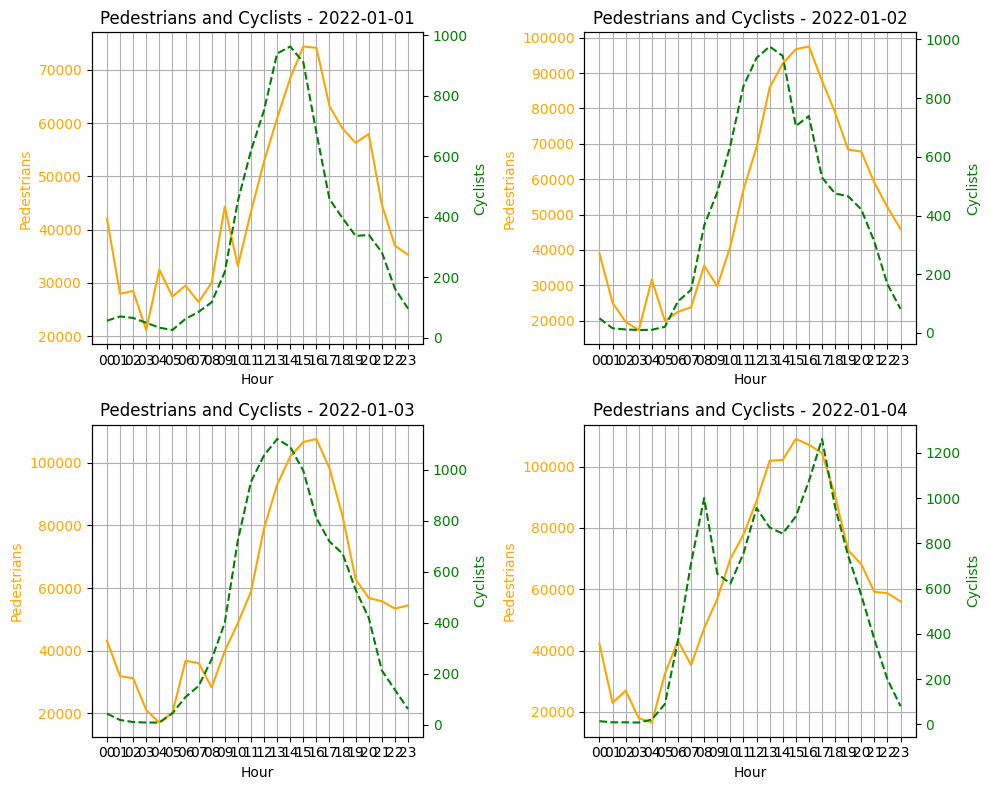

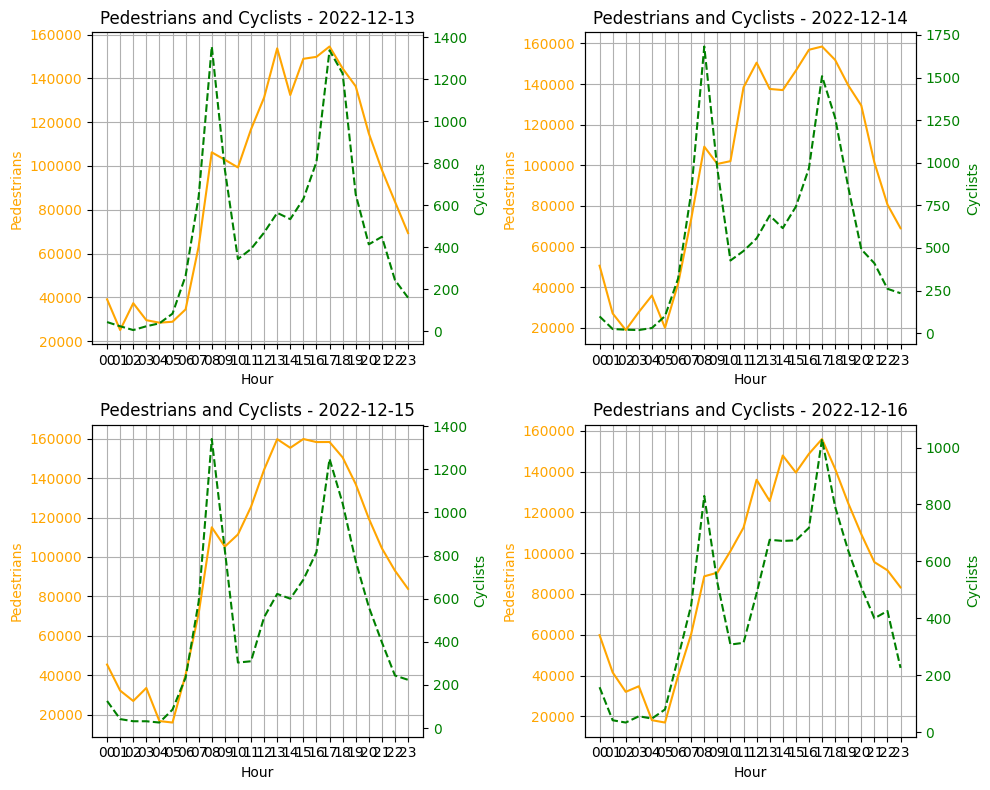

In [29]:
import matplotlib.pyplot as plt

def plot_dual_axis_pedestrians_cyclists(df, day_start, day_end):
    unique_days = df['Day_date'].unique()
    selected_days = unique_days[day_start-1:day_end]

    num_days = len(selected_days)
    ncols = 2  # 2 gráficos por linha
    nrows = (num_days + ncols - 1) // ncols  # calcula quantas linhas precisa

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()  # transforma matriz em vetor

    for i, day in enumerate(selected_days):
        df_day = df[df['Day_date'] == day]

        ax1 = axes[i]
        ax1.plot(df_day['Hour'], df_day['TotalPedestrians'], color='orange', label='Pedestrians')
        ax1.set_ylabel('Pedestrians', color='orange')
        ax1.tick_params(axis='y', labelcolor='orange')
        ax1.set_xlabel('Hour')
        ax1.set_title(f'Pedestrians and Cyclists - {day}')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(df_day['Hour'], df_day['TotalCyclists'], color='green', linestyle='--', label='Cyclists')
        ax2.set_ylabel('Cyclists', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    # Remove gráficos vazios se o número for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_dual_axis_pedestrians_cyclists(flow_df, day_start=1, day_end=4)
plot_dual_axis_pedestrians_cyclists(flow_df, day_start=347, day_end=350)

Mostly the pesdestrian and cycling flow overlap during day time, that checks out, for a larger scale look, we will plot the first days of each month. Comparing the first few days to the last, we can see there's much more people at the end of the year. We can also check that plotting by means from each hour in each mont

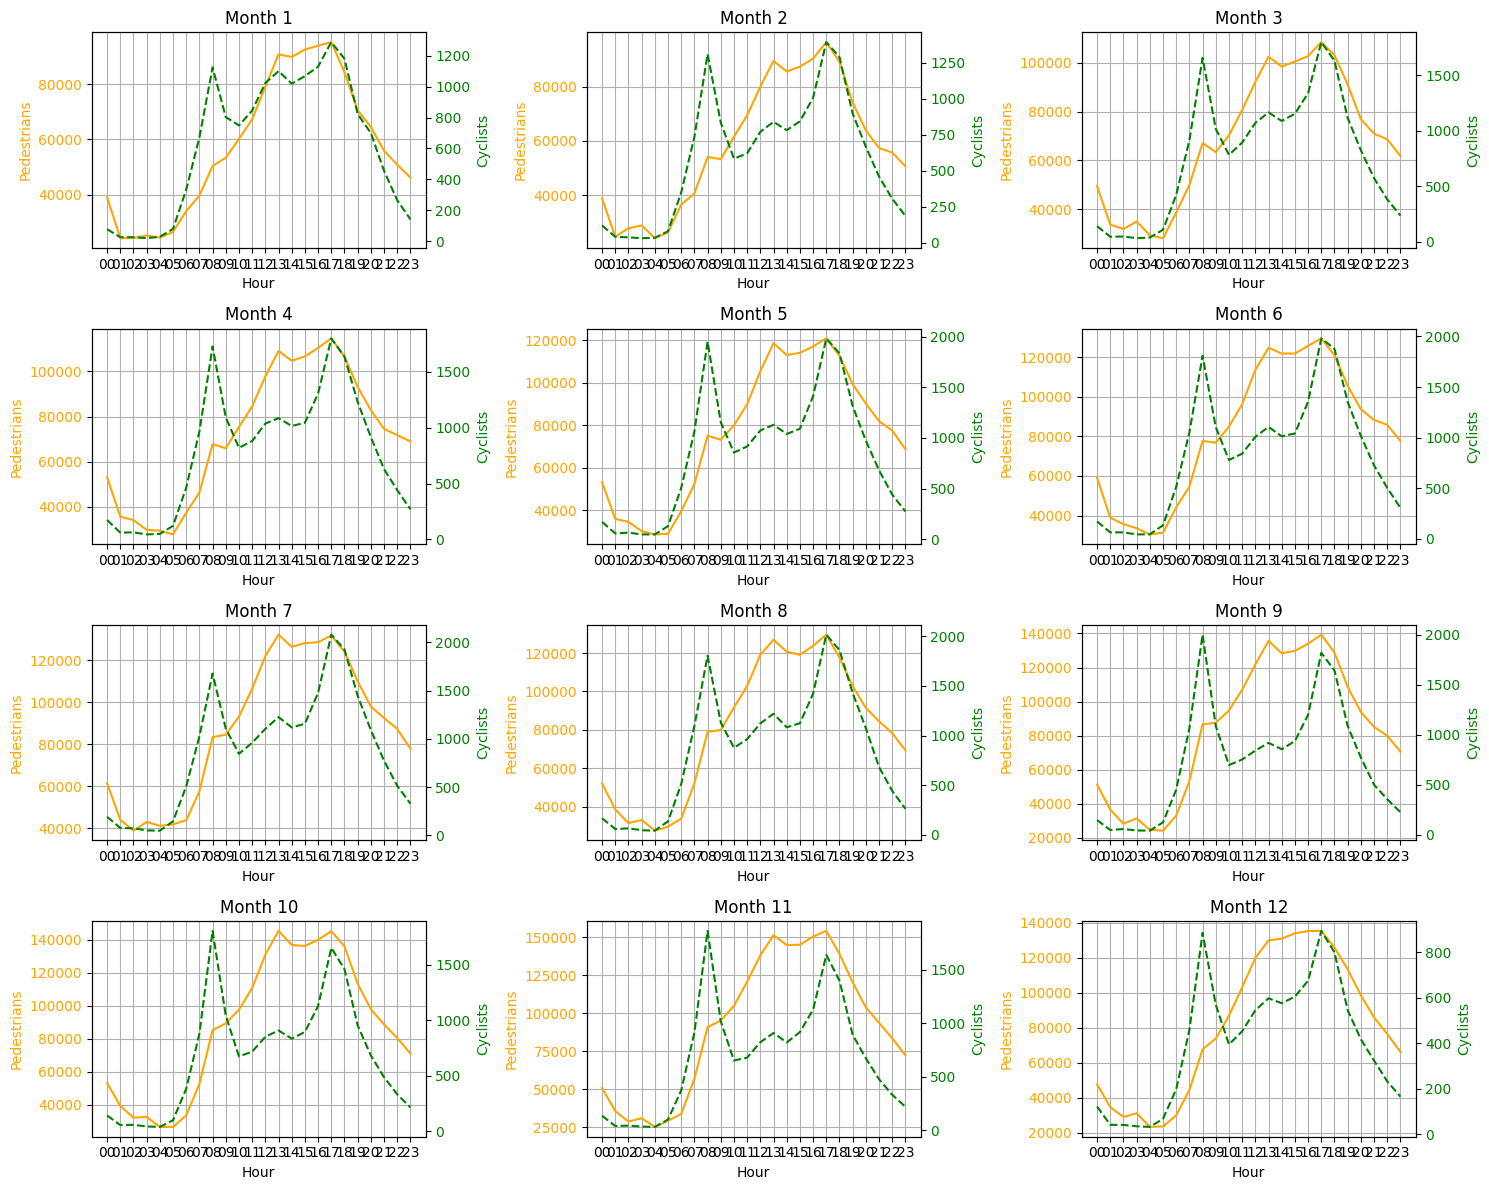

In [30]:
import matplotlib.pyplot as plt

def plot_monthly_mean_pedestrians_cyclists(df):
    df['Day_date'] = pd.to_datetime(df['Day_date'])

    df['Month'] = df['Day_date'].dt.month

    fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 12 meses, 4 linhas x 3 colunas
    axes = axes.flatten()

    for month in range(1, 13):
        df_month = df[df['Month'] == month]
        df_grouped = df_month.groupby('Hour').agg({'TotalPedestrians': 'mean', 'TotalCyclists': 'mean'}).reset_index()

        ax1 = axes[month-1]
        ax1.plot(df_grouped['Hour'], df_grouped['TotalPedestrians'], color='orange', label='Pedestrians')
        ax1.set_ylabel('Pedestrians', color='orange')
        ax1.tick_params(axis='y', labelcolor='orange')
        ax1.set_xlabel('Hour')
        ax1.set_title(f'Month {month}')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(df_grouped['Hour'], df_grouped['TotalCyclists'], color='green', linestyle='--', label='Cyclists')
        ax2.set_ylabel('Cyclists', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_monthly_mean_pedestrians_cyclists(flow_df)

We can also create the bases for the daily overall number of pedestriand and bykes each by summing the numbers for each column, and do that also for weeks and month

In [31]:
flow_df['Day_date'] = pd.to_datetime(flow_df['Day_date'])

daily_sum = flow_df.groupby('Day_date').agg({
    'TotalPedestrians': 'sum',
    'TotalCyclists': 'sum'
}).reset_index()

flow_df['Week'] = flow_df['Day_date'].dt.isocalendar().week
flow_df['Year'] = flow_df['Day_date'].dt.isocalendar().year

weekly_sum = flow_df.groupby(['Year', 'Week']).agg({
    'TotalPedestrians': 'sum',
    'TotalCyclists': 'sum'
}).reset_index()

flow_df['Month'] = flow_df['Day_date'].dt.month
flow_df['Year'] = flow_df['Day_date'].dt.year

monthly_sum = flow_df.groupby(['Year', 'Month']).agg({
    'TotalPedestrians': 'sum',
    'TotalCyclists': 'sum'
}).reset_index()

print("Daily:")
print(daily_sum.head())

print("\nWeekly:")
print(weekly_sum.head())

print("\nMonthly:")
print(monthly_sum.head())

Daily:
    Day_date  TotalPedestrians  TotalCyclists
0 2022-01-01         1069852.0         8162.0
1 2022-01-02         1264252.0         9452.0
2 2022-01-03         1365454.0        10550.0
3 2022-01-04         1507720.0        13133.0
4 2022-01-05         1452874.0        13496.0

Weekly:
   Year  Week  TotalPedestrians  TotalCyclists
0  2021    52         2334104.0        17614.0
1  2022     1         9736492.0        80849.0
2  2022     2         9554648.0       114071.0
3  2022     3         9734884.0       116054.0
4  2022     4        10051442.0       119076.0

Monthly:
   Year  Month  TotalPedestrians  TotalCyclists
0  2022      1        42819554.0       464192.0
1  2022      2        39369168.0       398058.0
2  2022      3        51365226.0       573930.0
3  2022      4        51859862.0       566137.0
4  2022      5        57031158.0       626104.0


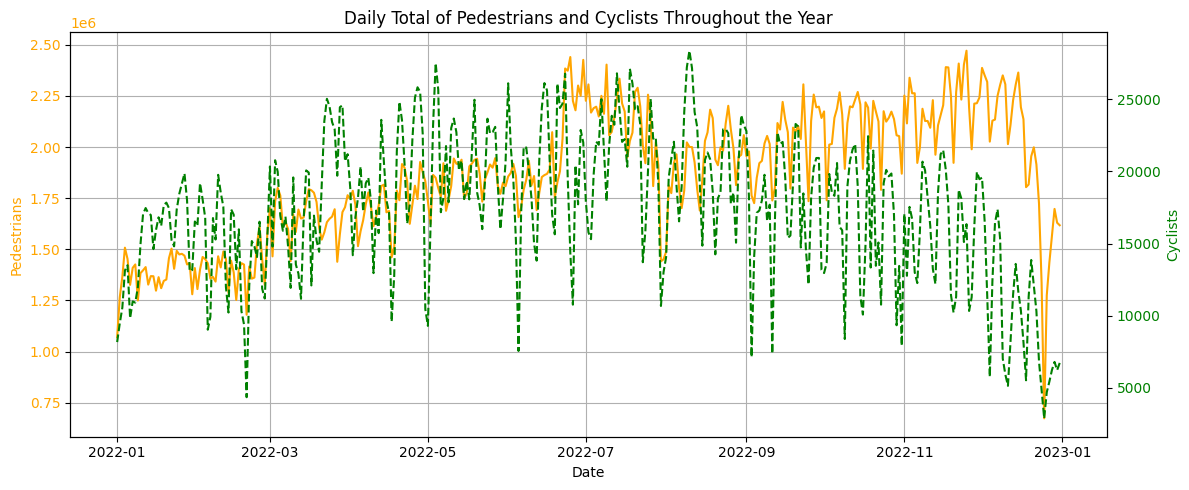

In [32]:
import matplotlib.pyplot as plt

def plot_yearly_daily_totals(daily_sum):
    fig, ax1 = plt.subplots(figsize=(12,5))

    ax1.plot(daily_sum['Day_date'], daily_sum['TotalPedestrians'], color='orange', label='Pedestrians')
    ax1.set_ylabel('Pedestrians', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.set_xlabel('Date')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(daily_sum['Day_date'], daily_sum['TotalCyclists'], color='green', linestyle='--', label='Cyclists')
    ax2.set_ylabel('Cyclists', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Daily Total of Pedestrians and Cyclists Throughout the Year')
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_yearly_daily_totals(daily_sum)

Turns out actually it seems like the number of pedestrians went up but the cyclists went a little down. We can plot it in weeks for a cleaner view

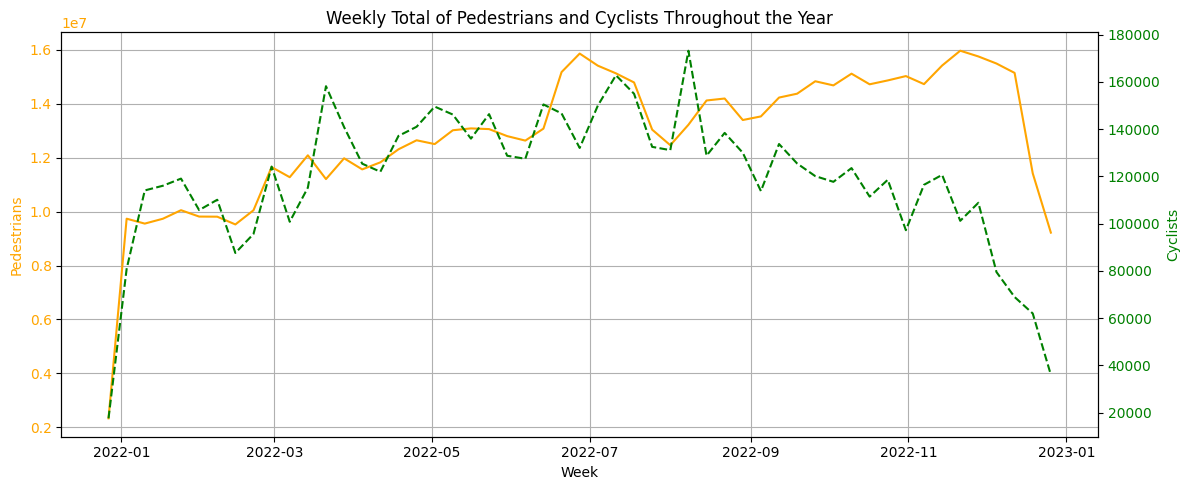

In [33]:
import matplotlib.pyplot as plt

def plot_yearly_weekly_totals(weekly_sum):
    weekly_sum['Week_start'] = pd.to_datetime(weekly_sum['Year'].astype(str) + '-W' + weekly_sum['Week'].astype(str) + '-1', format='%G-W%V-%u')

    fig, ax1 = plt.subplots(figsize=(12,5))

    ax1.plot(weekly_sum['Week_start'], weekly_sum['TotalPedestrians'], color='orange', label='Pedestrians')
    ax1.set_ylabel('Pedestrians', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.set_xlabel('Week')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(weekly_sum['Week_start'], weekly_sum['TotalCyclists'], color='green', linestyle='--', label='Cyclists')
    ax2.set_ylabel('Cyclists', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Weekly Total of Pedestrians and Cyclists Throughout the Year')
    plt.tight_layout()
    plt.show()

plot_yearly_weekly_totals(weekly_sum)

# Hourly and Daily air quallity

In [34]:
# 1. Base hourly
air_hourly_ts = air_ts_filtered.groupby(['Day_date', 'Hour'])[pollutants].mean().reset_index()

# 2. Base daily
air_daily_ts = air_ts_filtered.groupby('Day_date')[pollutants].mean().reset_index()

# Exibe as bases
print("Hourly:")
print(air_hourly_ts.head())

print("\nDaily:")
print(air_daily_ts.head())

Hourly:
     Day_date  Hour     NO_ugm3   NO2_ugm3    O3_ugm3   CO_mgm3    CO2_mgm3  \
0  2021-05-06    12   33.673475  30.956656  50.832197  0.406098  812.470590   
1  2021-05-06    13   53.379084  32.444628  51.430646  0.369155  807.394068   
2  2021-05-06    14   54.402984  24.050733  60.323931  0.395789  805.161146   
3  2021-05-06    15   43.020456  17.331008  66.758752  0.385880  799.874488   
4  2021-05-07     8  158.600886  68.273455  37.947875  0.450062  938.119909   

   PM25_ugm3  
0   4.856967  
1   4.655585  
2   5.117729  
3   6.459680  
4  10.128881  

Daily:
     Day_date     NO_ugm3   NO2_ugm3    O3_ugm3   CO_mgm3    CO2_mgm3  \
0  2021-05-06   50.769820  27.731534  56.170355  0.381856  806.019869   
1  2021-05-07  110.681767  47.480455  44.128436  0.475246  868.542723   
2  2021-05-10   63.942942  22.629391  63.232522  0.463304  828.542058   
3  2021-05-11   86.025758  46.042063  62.062323  0.419108  845.408502   
4  2021-05-14   73.936124  43.438385  51.740931  0.493

# Nova seção

Step 2 – Load air quality data and calculate weekly means

In [35]:
air

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PMch1_perL,PMch2_perL,PMch3_perL,PMch4_perL,PMch5_perL,PMch6_perL,PM25_ugm3
0,2022-04-07 14:56:36 UTC,53.346434,-6.263997,-13.526,11.724,NaN,0.293,765.328,6240.0,1860.0,1380.0,480.0,60.0,120.0,4.927
1,2022-04-07 14:56:37 UTC,53.346434,-6.263997,-29.957,4.441,NaN,0.291,NaN,4800.0,1380.0,1020.0,240.0,240.0,60.0,4.240
2,2022-04-07 14:56:38 UTC,53.346434,-6.263997,-9.260,8.725,59.109,0.299,NaN,6300.0,1800.0,1140.0,600.0,60.0,60.0,4.204
3,2022-04-07 14:56:39 UTC,53.346434,-6.263997,-22.847,7.023,NaN,0.295,NaN,5040.0,1800.0,1080.0,300.0,60.0,60.0,3.410
4,2022-04-07 14:56:40 UTC,53.346434,-6.263997,-9.225,15.591,NaN,0.296,763.271,5580.0,1920.0,1260.0,480.0,60.0,60.0,4.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030138,2022-04-07 14:56:31 UTC,53.346434,-6.263997,-13.114,5.921,NaN,0.304,771.618,5940.0,1440.0,720.0,600.0,120.0,60.0,4.169
5030139,2022-04-07 14:56:32 UTC,53.346434,-6.263997,-22.120,5.064,NaN,0.304,771.599,5460.0,1380.0,960.0,480.0,180.0,120.0,5.207
5030140,2022-04-07 14:56:33 UTC,53.346434,-6.263997,-17.668,4.208,56.223,0.297,769.511,5340.0,1860.0,840.0,240.0,240.0,0.0,3.463
5030141,2022-04-07 14:56:34 UTC,53.346434,-6.263997,-7.020,5.286,NaN,0.303,767.451,5160.0,1800.0,900.0,420.0,120.0,120.0,4.740


In [36]:
daily_sum['Day_date'] = pd.to_datetime(daily_sum['Day_date'])
air_daily_ts['Day_date'] = pd.to_datetime(air_daily_ts['Day_date'])

merged = pd.merge(daily_sum, air_daily_ts, on='Day_date')
merged['TotalPeople'] = merged['TotalCyclists']+merged['TotalPedestrians']
merged.head(5)

,Day_date,TotalPedestrians,TotalCyclists,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,TotalPeople
0,2022-01-04,1507720.0,13133.0,54.296080,35.461281,23.070083,0.447103,813.211227,12.029842,1520853.0
1,2022-01-06,1325880.0,9816.0,48.012041,22.672523,49.085975,0.383517,799.645710,7.794838,1335696.0
2,2022-01-07,1409220.0,10986.0,61.317496,38.551314,30.939748,0.435353,821.270473,5.161293,1420206.0
3,2022-01-10,1383256.0,14922.0,107.868650,48.136742,33.104644,0.535064,863.108651,5.087196,1398178.0
4,2022-01-11,1396970.0,17044.0,125.650085,70.437768,9.731029,0.507056,879.816133,19.383519,1414014.0


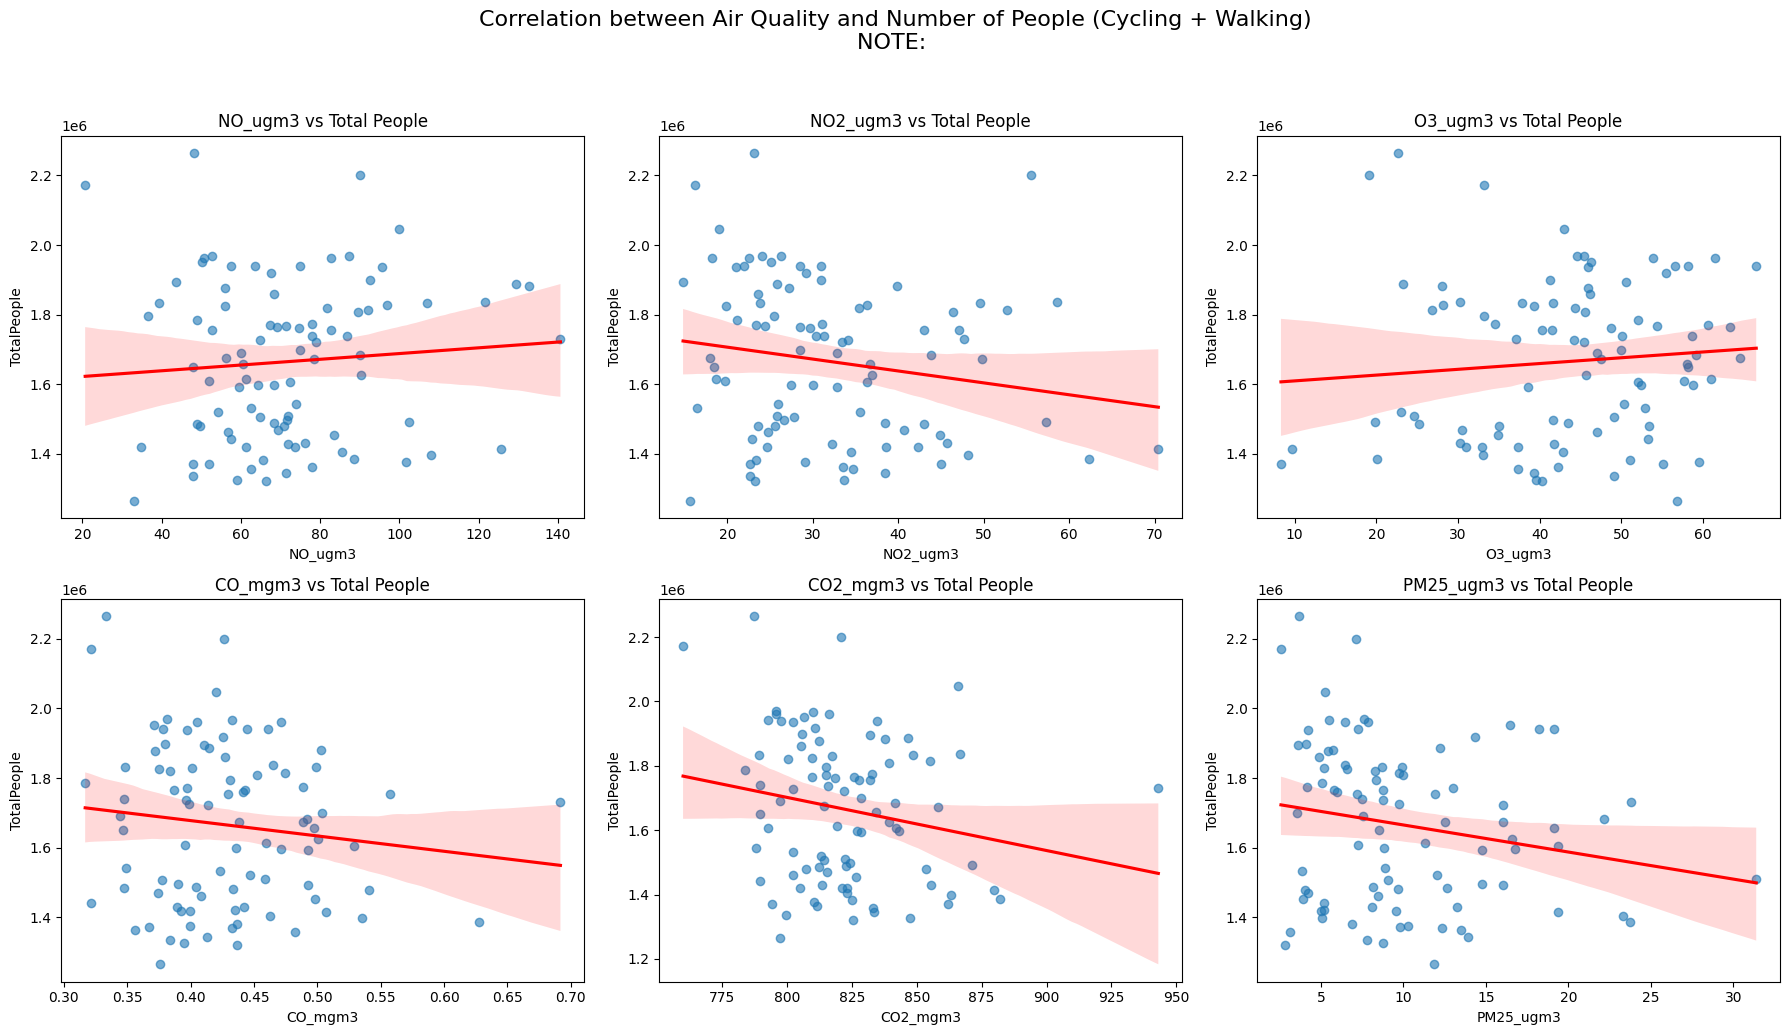

In [37]:
# Plot scatter plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x=pollutant,
        y='TotalPeople',
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'{pollutant} vs Total People')

plt.suptitle('Correlation between Air Quality and Number of People (Cycling + Walking)\nNOTE: ', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

This hypothesis was tested by analyzing the daily correlation between pedestrian and cyclist counts and the concentration of various air pollutants. The central assumption was that higher levels of active transportation (walking and cycling) would be associated with lower pollutant concentrations, thereby improving air quality.

## Pollutant-by-pollutant justification:
- Nitric Oxide (NO): the correlation observed was positive, meaning that on days with more people walking or cycling, NO levels were higher. This result contradicts the hypothesis. One possible explanation is that increased pedestrian and cyclist counts may coincide with higher overall urban activity, including increased vehicular traffic or reduced atmospheric dispersion, leading to elevated NO concentrations.

- Nitrogen Dioxide (NO₂): the correlation was negative, which supports the hypothesis. As NO₂ is a direct product of vehicle emissions, this suggests that higher active transportation levels may be associated with reduced vehicular traffic, resulting in lower NO₂ concentrations.

- Ozone (O₃): the correlation was again positive, contradicting the hypothesis. However, ozone is a secondary pollutant formed through photochemical reactions involving NOx and sunlight. Sunny days tend to both increase ozone levels and encourage outdoor activities, which likely explains this positive relationship.

- Carbon Monoxide (CO): the correlation was negative, which supports the hypothesis. CO primarily originates from vehicle emissions, and the negative correlation suggests that more active transportation correlates with reduced vehicular activity, leading to lower CO levels.

- Carbon Dioxide (CO₂): the correlation was also negative, which supports the hypothesis. Although CO₂ has a relatively stable global concentration, local variations can occur due to traffic patterns. The negative correlation indicates that higher pedestrian and cyclist counts may correspond to reduced local CO₂ emissions.

- Particulate Matter (PM2.5), the correlation was negative, further supporting the hypothesis. PM2.5 is emitted from vehicle exhaust, industrial processes, and construction activities. The data suggests that higher levels of active mobility are associated with lower PM2.5 concentrations, possibly due to reduced traffic congestion.

## Conclusion:

The analysis provides partial support for the hypothesis that increased active transportation contributes to improved air quality. Pollutants such as NO₂, CO, CO₂, and PM2.5 exhibited negative correlations with pedestrian and cyclist counts, which aligns with the hypothesis. However, NO and O₃ presented positive correlations, contradicting the expected outcome. In particular, the behavior of ozone is likely influenced by sunny weather conditions, which simultaneously increase ozone formation and encourage outdoor activities.

Although the observed correlations were generally weak to moderate, the results indicate that active transportation can play a role in improving air quality, but external factors such as weather conditions, urban airflow patterns, and traffic dynamics must also be considered. Future studies should aim for spatial alignment between air quality sensors and mobility counters, as well as control for additional environmental variables, to validate these findings more robustly.

# NEW *TOPIC*

In [38]:
import pandas as pd
import os

# Lista com os nomes dos arquivos SCATS
scats_files = [
    'SCATSJuly2022.csv',
    'SCATSAugust2022.csv',
    'SCATSSeptember2022.csv',
    'SCATSOctober2022.csv',
    'SCATSNovember2022.csv',
    'SCATSDecember2022.csv'
]

# Lista para armazenar os dataframes
dfs = []

# Loop para carregar cada arquivo e adicionar à lista
for file in scats_files:
    df = pd.read_csv(file, usecols=['End_Time', 'Sum_Volume'])
    dfs.append(df)

# Concatenar todos os dataframes em um único dataframe
scats_all = pd.concat(dfs, ignore_index=True)

# Exibir informações básicas do dataframe concatenado
print("Formato final do dataframe SCATS:", scats_all.shape)
print(scats_all.columns)
scats_all.head()


Formato final do dataframe SCATS: (60538868, 2)
Index(['End_Time', 'Sum_Volume'], dtype='object')


,End_Time,Sum_Volume
0,20220731120000,0
1,20220731120000,0
2,20220731120000,0
3,20220731120000,0
4,20220731120000,248


In [39]:
# Converter 'End_Time' para datetime (timestamp)
import pandas as pd
scats_all['End_Time'] = pd.to_datetime(scats_all['End_Time'], format='%Y%m%d%H%M%S')

# Criar coluna 'Date' com apenas a data (sem hora)
scats_all['Day_date'] = scats_all['End_Time'].dt.date

# Agrupar o volume de veículos por dia (soma diária)
traffic_daily = scats_all.groupby(['Day_date'])['Sum_Volume'].sum().reset_index()
traffic_daily.rename(columns={'Sum_Volume': 'TotalVehicles'}, inplace=True)

# Exibir o resultado
traffic_daily.head()


,Day_date,TotalVehicles
0,2022-07-01,16530415
1,2022-07-02,14431932
2,2022-07-03,13151451
3,2022-07-04,14908107
4,2022-07-05,15242803


In [44]:
traffic_daily['Day_date'] = pd.to_datetime(traffic_daily['Day_date'])
merged_traffic_pedcycle = pd.merge(daily_sum, traffic_daily, on='Day_date')
merged_traffic_pedcycle['TotalPeople'] = merged_traffic_pedcycle['TotalCyclists']+ merged_traffic_pedcycle['TotalPedestrians']
merged_traffic_pedcycle


,Day_date,TotalPedestrians,TotalCyclists,TotalVehicles,TotalPeople
0,2022-07-01,2226208.0,17911.0,16530415,2244119.0
1,2022-07-02,2306294.0,15782.0,14431932,2322076.0
2,2022-07-03,2168478.0,15301.0,13151451,2183779.0
3,2022-07-04,2190100.0,19763.0,14908107,2209863.0
4,2022-07-05,2197490.0,22073.0,15242803,2219563.0
...,...,...,...,...,...
179,2022-12-27,1434552.0,5414.0,10980002,1439966.0
180,2022-12-28,1565770.0,6226.0,12207515,1571996.0
181,2022-12-29,1697346.0,6786.0,12731978,1704132.0
182,2022-12-30,1629764.0,6214.0,13077396,1635978.0


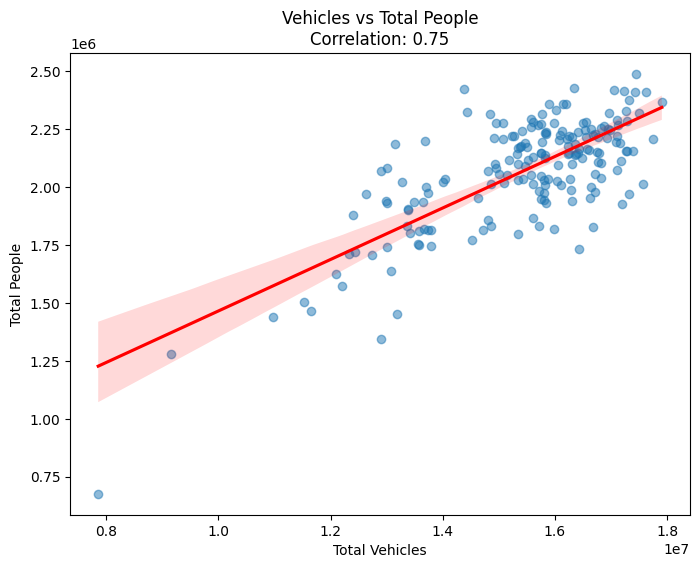

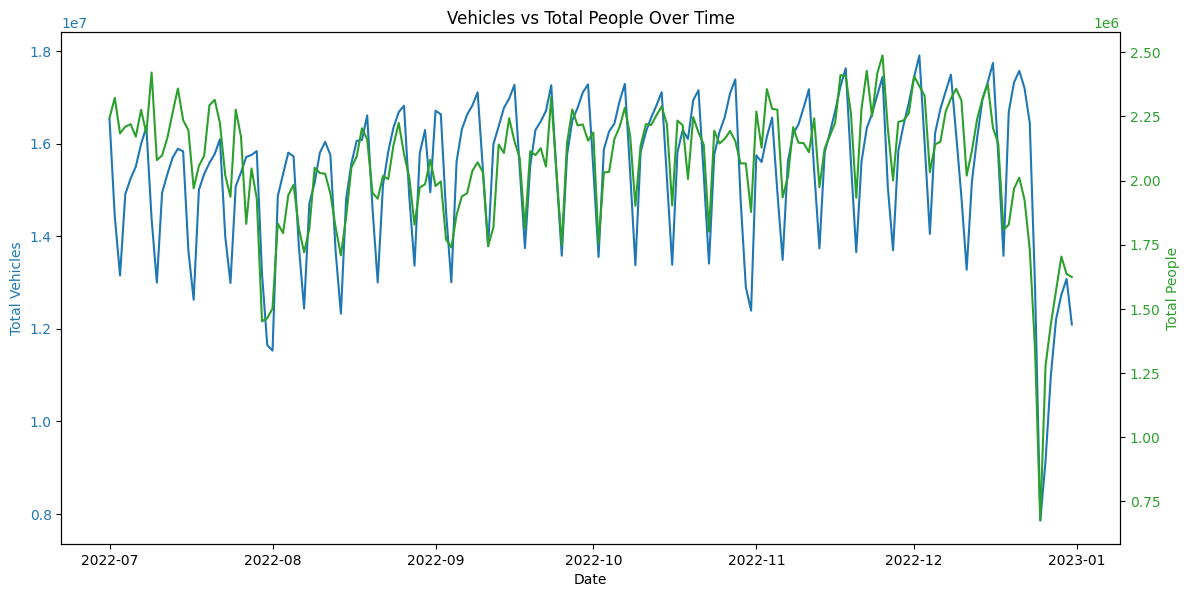

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Scatter plot com linha de regressão (Vehicles vs Total People)
plt.figure(figsize=(8,6))
sns.regplot(data=merged_traffic_pedcycle,
            x='TotalVehicles',
            y='TotalPeople',
            scatter_kws={'alpha':0.5},
            line_kws={'color':'red'})
corr, _ = pearsonr(merged_traffic_pedcycle['TotalVehicles'], merged_traffic_pedcycle['TotalPeople'])
plt.title(f'Vehicles vs Total People\nCorrelation: {corr:.2f}')
plt.xlabel('Total Vehicles')
plt.ylabel('Total People')
plt.show()

# Gráfico de linhas com eixo duplo (Vehicles vs Total People)
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Vehicles', color=color)
ax1.plot(merged_traffic_pedcycle['Day_date'], merged_traffic_pedcycle['TotalVehicles'], color=color, label='Vehicles')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # segundo eixo y
color = 'tab:green'
ax2.set_ylabel('Total People', color=color)
ax2.plot(merged_traffic_pedcycle['Day_date'], merged_traffic_pedcycle['TotalPeople'], color=color, label='Total People')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Vehicles vs Total People Over Time')
plt.show()
